## Taller 7

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Set the environment flag for determinism
tf.config.experimental.enable_op_determinism()

In [3]:
df = pd.read_csv('heart.csv')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Descripción de las variables:

https://archive.ics.uci.edu/dataset/45/heart+disease


Exploremos el tamaño del df

In [5]:
df.shape

(303, 14)

Identificamos NAs en los datos

In [6]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Definimos listas para las variables categóricas enteras, categóricas string y numéricas.

In [7]:
## Reducimos el numero de variables categoricas a 4
cat_int_feats = ['sex', 'cp', 'fbs', 'exang']

In [8]:
cat_str_feats = ['thal']

In [9]:
# Reducimos el numero de variables numericas a 4
num_feats = ['age', 'chol', 'oldpeak', 'slope']

Agregamos las listas de categorías

In [10]:
feats_ordered = cat_int_feats+cat_str_feats+num_feats

Reordenamos el dataframe de acuerdo con el tipo de variable

In [11]:
df = df[feats_ordered+['target']]

In [12]:
df.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
0,1,1,1,0,fixed,63,233,2.3,3,0
1,1,4,0,1,normal,67,286,1.5,2,1
2,1,4,0,1,reversible,67,229,2.6,2,0
3,1,3,0,0,normal,37,250,3.5,3,0
4,0,2,0,0,normal,41,204,1.4,1,0


In [13]:
df.columns

Index(['sex', 'cp', 'fbs', 'exang', 'thal', 'age', 'chol', 'oldpeak', 'slope',
       'target'],
      dtype='object')

In [14]:
df["target"].unique()

array([0, 1], dtype=int64)

In [15]:
df.dtypes

sex          int64
cp           int64
fbs          int64
exang        int64
thal        object
age          int64
chol         int64
oldpeak    float64
slope        int64
target       int64
dtype: object

Separamos los datos en entrenamiento, validación y prueba

In [16]:
train = df.sample(frac=0.8, random_state=100)
train.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
69,0,4,0,0,normal,35,183,1.4,1,0
300,1,4,0,0,reversible,65,254,2.8,2,1
220,1,1,0,0,normal,59,204,0.8,1,0
134,1,3,1,0,reversible,42,240,0.8,3,0
7,0,4,0,1,normal,57,354,0.6,1,0


In [17]:
train.shape

(242, 10)

In [18]:
test = df.drop(train.index)
test.head()

,sex,cp,fbs,exang,thal,age,chol,oldpeak,slope,target
0,1,1,1,0,fixed,63,233,2.3,3,0
2,1,4,0,1,reversible,67,229,2.6,2,0
4,0,2,0,0,normal,41,204,1.4,1,0
8,1,4,0,0,reversible,63,254,1.4,2,1
13,1,2,0,0,reversible,44,263,0.0,1,0


In [19]:
val = train.sample(frac=0.2, random_state=100)

In [20]:
val.shape

(48, 10)

In [21]:
train = train.drop(val.index)

In [22]:
print(train.shape)
print(val.shape)
print(test.shape)

(194, 10)
(48, 10)
(61, 10)


Calculamos estadísticas de cada variable numérica

In [23]:
train.describe()

,sex,cp,fbs,exang,age,chol,oldpeak,slope,target
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.664948,3.097938,0.134021,0.319588,54.953608,249.974227,0.990722,1.577320,0.257732
std,0.473230,1.030969,0.341556,0.467523,8.754150,52.803226,1.110625,0.590689,0.438517
min,0.000000,0.000000,0.000000,0.000000,34.000000,126.000000,0.000000,1.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,49.000000,215.750000,0.000000,1.000000,0.000000
50%,1.000000,3.000000,0.000000,0.000000,56.000000,243.000000,0.600000,2.000000,0.000000
75%,1.000000,4.000000,0.000000,1.000000,61.000000,281.000000,1.600000,2.000000,1.000000
max,1.000000,4.000000,1.000000,1.000000,77.000000,564.000000,4.400000,3.000000,1.000000


Función para convertir de dataframe (pandas) a dataset (tensorflow), separando características y etiquetas

In [24]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [25]:
train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)
test_ds = dataframe_to_dataset(test)

In [26]:
type(train_ds)

tensorflow.python.data.ops.shuffle_op._ShuffleDataset

Ejemplo de cómo queda el tf.dataset

In [27]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=65>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=254>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.8>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=2>}
Target: tf.Tensor(1, shape=(), dtype=int64)


Separamos los datos de entrenamiento, validación y prueba en lotes

In [28]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Función para codificar variables numéricas (Keras docs)

In [29]:
def encode_numerical_feature(feature, name, dataset):
    # Crea capa de normalización para este feature
    normalizer = keras.layers.Normalization()

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende las estadísticas de los datos (media, varianza)
    normalizer.adapt(feature_ds)

    # Aplica la normalización a la variable
    encoded_feature = normalizer(feature)
    return encoded_feature

Función para codificar variables categóricas (Keras docs)

In [30]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Crea una capa Lookup para retornas variables 0/1 (dummies)
    # lookup: busca el valor correspondiente de la variable categórica
    lookup = lookup_class(output_mode="binary")

    # Prepara el dataset para considerar únicamente la feature de interés (name)
    feature_ds = dataset.map(lambda x, y: x[name]) # selecciona variable
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1)) # deja el tensor de una dimensión

    # Aprende el conjunto de posibles valores que toma la variable categórica y asigna enteros
    lookup.adapt(feature_ds)

    # Aplica la conversión de categorías a enteros
    encoded_feature = lookup(feature)
    return encoded_feature

Creamos una lista de inputs para el modelo, de acuerdo con cada tipo de variable

In [31]:
inputs = []
for i in cat_int_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

In [32]:
for i in cat_str_feats:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [33]:
for i in num_feats:
  inputs.append(keras.Input(shape=(1,), name=i))

In [34]:
for i in inputs:
   print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='sex'), name='sex', description="created by layer 'sex'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='cp'), name='cp', description="created by layer 'cp'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='fbs'), name='fbs', description="created by layer 'fbs'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.int64, name='exang'), name='exang', description="created by layer 'exang'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.string, name='thal'), name='thal', description="created by layer 'thal'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='age'), name='age', description="created by layer 'age'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='chol'), name='chol', description="created by layer 'chol'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='oldpeak')

Creamos una lista de variables codificadas/normalizadas de acuerdo con su tipo, empleando las funciones de codificación/normalización

In [35]:
feats_encoded=[]

In [36]:
for i,feat in enumerate(cat_int_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[i], feat, train_ds, False)
  )

In [37]:
len_feats = len(feats_encoded)
len_feats

4

In [38]:
for i,feat in enumerate(cat_str_feats):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

In [39]:
len_feats = len(feats_encoded)
len_feats

5

In [40]:
for i,feat in enumerate(num_feats):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

In [41]:
for i in feats_encoded:
  print(i)

KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup/bincount/DenseBincount:0', description="created by layer 'integer_lookup'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='integer_lookup_1/bincount/DenseBincount:0', description="created by layer 'integer_lookup_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup_2/bincount/DenseBincount:0', description="created by layer 'integer_lookup_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='integer_lookup_3/bincount/DenseBincount:0', description="created by layer 'integer_lookup_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='string_lookup/bincount/DenseBincount:0', description="created by layer 'string_lookup'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/trued

Creamos una capa concatenando todas las variables codificadas

In [42]:
all_feats = keras.layers.concatenate(feats_encoded)

In [43]:
type(all_feats)

keras.src.engine.keras_tensor.KerasTensor

Agregamos una capa densa con 32 neuronas y función de activación relu

In [44]:
model_layers = keras.layers.Dense(32, activation='relu')(all_feats)

Agregamos la capa de salida con 1 neurona (probabilidad de sufrir la enfermedad cardiada) y función de activación sigmoide

In [45]:
model_layers = keras.layers.Dense(1, activation='sigmoid')(model_layers)

Creamos el modelo con las capas ya creadas y las variables de entrada

In [46]:
model = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])


In [48]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Aseguramos que Keras use TensorFlow como backend, para asegurar que el modelo pueda usar strings como entradas

In [49]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                              

Entrenamos el modelo con los datos en el formato tf.Dataset

In [51]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50

7/7 [==============================] - 4s 176ms/step - loss: 0.6501 - accuracy: 0.7216 - precision: 0.2500 - recall: 0.0400 - roc_auc: 0.3639 - val_loss: 0.6034 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.0833 - val_roc_auc: 0.5579
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.6131 - accuracy: 0.7320 - precision: 0.2500 - recall: 0.0200 - roc_auc: 0.4906 - val_loss: 0.5706 - val_accuracy: 0.7708 - val_precision: 1.0000 - val_recall: 0.0833 - val_roc_auc: 0.6794
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5834 - accuracy: 0.7423 - precision: 0.5000 - recall: 0.0200 - roc_auc: 0.6221 - val_loss: 0.5433 - val_accuracy: 0.7708 - val_precision: 1.0000 - val_recall: 0.0833 - val_roc_auc: 0.7674
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5593 - accuracy: 0.7371 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.7084 - val_loss: 0.5197 - val_accuracy: 0.7708 - val_precisi

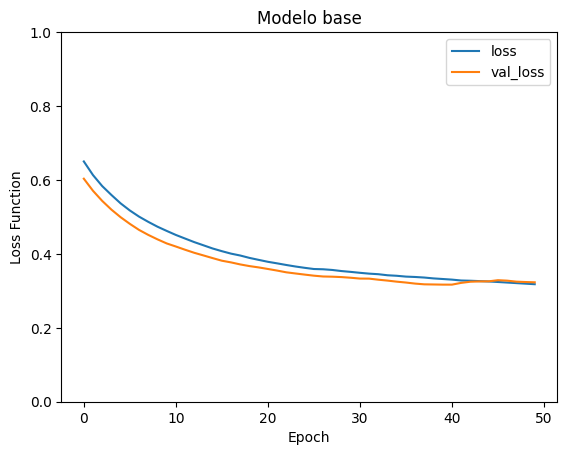

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.plot(history.history['accuracy'],label='accuracy')
# plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Modelo base")
plt.legend()

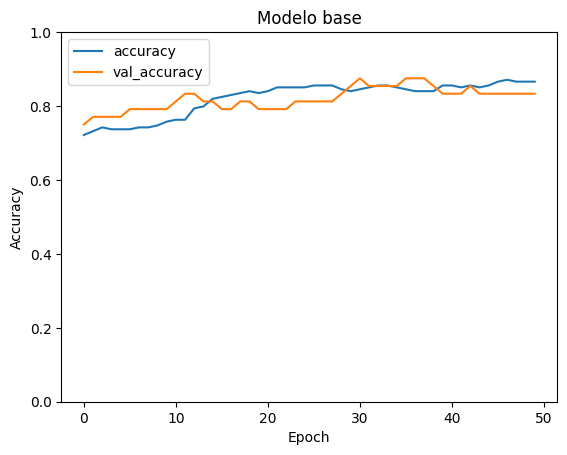

In [53]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Modelo base")
plt.legend()

In [54]:
results = model.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados para modelo base")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

Resultados para modelo base
loss: 0.4067428410053253
accuracy: 0.7704917788505554
precision: 0.7333333492279053
recall: 0.523809552192688
roc_auc: 0.898809552192688


## Punto 3 - 1 (optimizador = SGD)

In [55]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [56]:
optimizer_exp1 = SGD(learning_rate=0.01, momentum=0.9)

In [57]:
model_exp1 = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [58]:
model_exp1.compile(optimizer=optimizer_exp1, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])


In [59]:
keras.utils.plot_model(model_exp1, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [60]:
model_exp1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [61]:
history_exp1 = model_exp1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 5s 382ms/step - loss: 0.3174 - accuracy: 0.8660 - precision_1: 0.7727 - recall_1: 0.6800 - roc_auc: 0.9193 - val_loss: 0.3222 - val_accuracy: 0.8333 - val_precision_1: 0.6250 - val_recall_1: 0.8333 - val_roc_auc: 0.9144
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 0.3163 - accuracy: 0.8660 - precision_1: 0.7727 - recall_1: 0.6800 - roc_auc: 0.9205 - val_loss: 0.3234 - val_accuracy: 0.8333 - val_precision_1: 0.6250 - val_recall_1: 0.8333 - val_roc_auc: 0.9144
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 0.3155 - accuracy: 0.8711 - precision_1: 0.7778 - recall_1: 0.7000 - roc_auc: 0.9193 - val_loss: 0.3299 - val_accuracy: 0.8333 - val_precision_1: 0.6250 - val_recall_1: 0.8333 - val_roc_auc: 0.9132
Epoch 4/50
7/7 [==============================] - 0s 32ms/step - loss: 0.3132 - accuracy: 0.8711 - precision_1: 0.7778 - recall_1: 0.7000 - roc_auc: 0.9206 - val_loss: 0.3295 - val_accuracy: 0

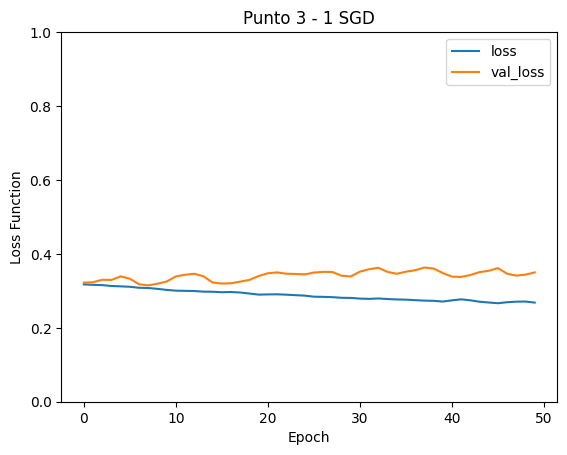

In [62]:
import matplotlib.pyplot as plt
plt.plot(history_exp1.history['loss'], label='loss')
plt.plot(history_exp1.history['val_loss'], label='val_loss')
# plt.plot(history.history['accuracy'],label='accuracy')
# plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 3 - 1 SGD")
plt.legend()

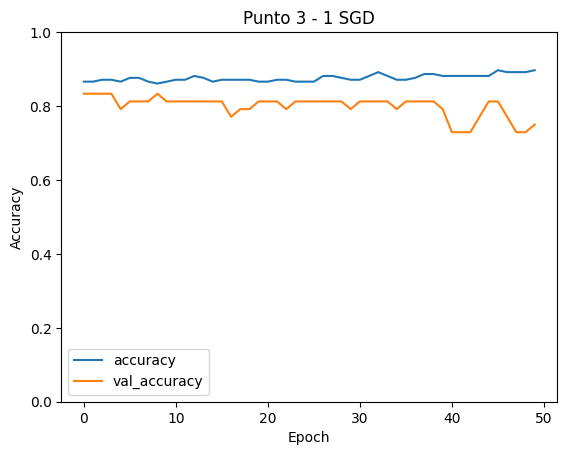

In [63]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history_exp1.history['accuracy'],label='accuracy')
plt.plot(history_exp1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 3 - 1 SGD")
plt.legend()

In [64]:
results_exp1 = model_exp1.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 3 - 1 SGD")
for name, value in zip(model_exp1.metrics_names, results_exp1):
    print(f"{name}: {value}")

Resultados Punto 3 - 1 SGD
loss: 0.4406590163707733
accuracy: 0.7868852615356445
precision_1: 0.7222222089767456
recall_1: 0.6190476417541504
roc_auc: 0.8886904716491699


## Punto 3 - 2 (RMS)

In [65]:
optimizer_exp2 = RMSprop(learning_rate=0.001)

In [66]:
model_exp2 = keras.Model(inputs, model_layers)

Compilamos el modelo, definiendo optimizador, función de pérdida y métricas adicionales a capturar

In [67]:
model_exp2.compile(optimizer=optimizer_exp2, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])


In [68]:
model_exp2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [69]:
history_exp2 = model_exp2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 4s 197ms/step - loss: 0.2687 - accuracy: 0.8969 - precision_2: 0.8261 - recall_2: 0.7600 - roc_auc: 0.9445 - val_loss: 0.3538 - val_accuracy: 0.7708 - val_precision_2: 0.5294 - val_recall_2: 0.7500 - val_roc_auc: 0.8819
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 0.2649 - accuracy: 0.8969 - precision_2: 0.8261 - recall_2: 0.7600 - roc_auc: 0.9455 - val_loss: 0.3525 - val_accuracy: 0.7917 - val_precision_2: 0.5556 - val_recall_2: 0.8333 - val_roc_auc: 0.8831
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.2640 - accuracy: 0.8866 - precision_2: 0.8182 - recall_2: 0.7200 - roc_auc: 0.9461 - val_loss: 0.3587 - val_accuracy: 0.8125 - val_precision_2: 0.5789 - val_recall_2: 0.9167 - val_roc_auc: 0.8843
Epoch 4/50
7/7 [==============================] - 0s 19ms/step - loss: 0.2625 - accuracy: 0.8969 - precision_2: 0.8261 - recall_2: 0.7600 - roc_auc: 0.9460 - val_loss: 0.3591 - val_accuracy: 0

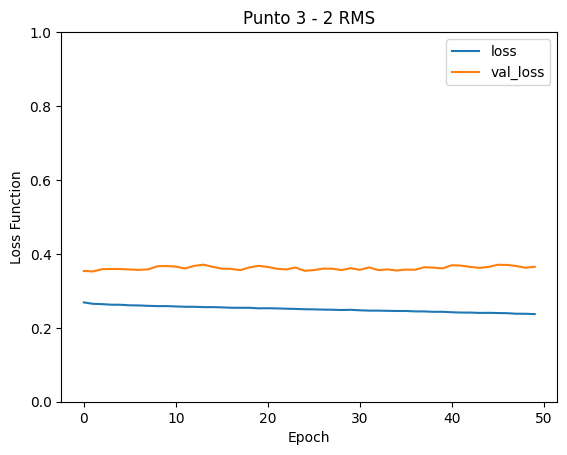

In [70]:
import matplotlib.pyplot as plt
plt.plot(history_exp2.history['loss'], label='loss')
plt.plot(history_exp2.history['val_loss'], label='val_loss')
# plt.plot(history.history['accuracy'],label='accuracy')
# plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 3 - 2 RMS")
plt.legend()

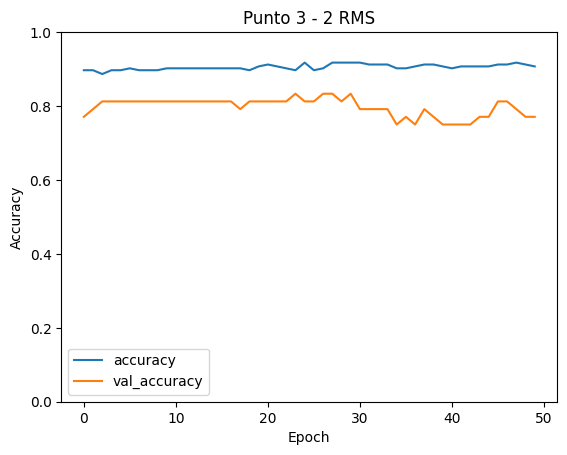

In [71]:
import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history_exp2.history['accuracy'],label='accuracy')
plt.plot(history_exp2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 3 - 2 RMS")
plt.legend()

In [72]:
results_exp2 = model_exp2.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 3 - 2 RMS")
for name, value in zip(model_exp2.metrics_names, results_exp1):
    print(f"{name}: {value}")

Resultados Punto 3 - 2 RMS
loss: 0.4406590163707733
accuracy: 0.7868852615356445
precision_2: 0.7222222089767456
recall_2: 0.6190476417541504
roc_auc: 0.8886904716491699


## Punto 4 - 1 (tasa = 0.01)

In [73]:
model_4_1 = keras.Model(inputs, model_layers)

In [74]:
learning_rate_1 = 0.01
optimizer = Adam(learning_rate=learning_rate_1)
model_4_1.compile(optimizer=optimizer, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [75]:
model_4_1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [76]:
history_4_1 = model_4_1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 4s 155ms/step - loss: 0.2550 - accuracy: 0.9124 - precision_3: 0.8235 - recall_3: 0.8400 - roc_auc: 0.9488 - val_loss: 0.3615 - val_accuracy: 0.7500 - val_precision_3: 0.5000 - val_recall_3: 0.5833 - val_roc_auc: 0.8681
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.2628 - accuracy: 0.8918 - precision_3: 0.9143 - recall_3: 0.6400 - roc_auc: 0.9551 - val_loss: 0.3521 - val_accuracy: 0.7500 - val_precision_3: 0.5000 - val_recall_3: 0.5833 - val_roc_auc: 0.8773
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 0.2489 - accuracy: 0.8918 - precision_3: 0.8222 - recall_3: 0.7400 - roc_auc: 0.9494 - val_loss: 0.4068 - val_accuracy: 0.7708 - val_precision_3: 0.5263 - val_recall_3: 0.8333 - val_roc_auc: 0.8692
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.2391 - accuracy: 0.9124 - precision_3: 0.8235 - recall_3: 0.8400 - roc_auc: 0.9551 - val_loss: 0.3998 - val_accuracy: 0

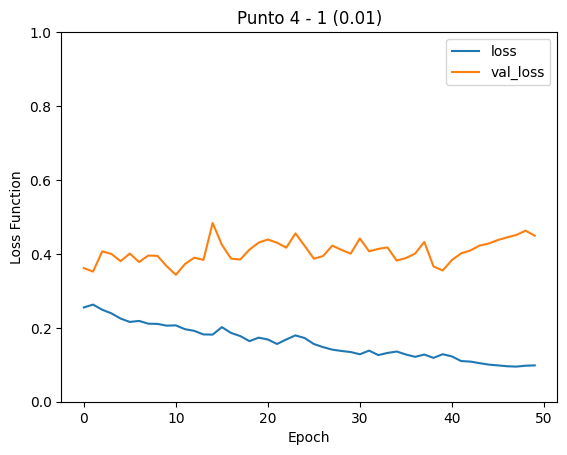

In [77]:
import matplotlib.pyplot as plt
plt.plot(history_4_1.history['loss'], label='loss')
plt.plot(history_4_1.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 4 - 1 (0.01)")
plt.legend()

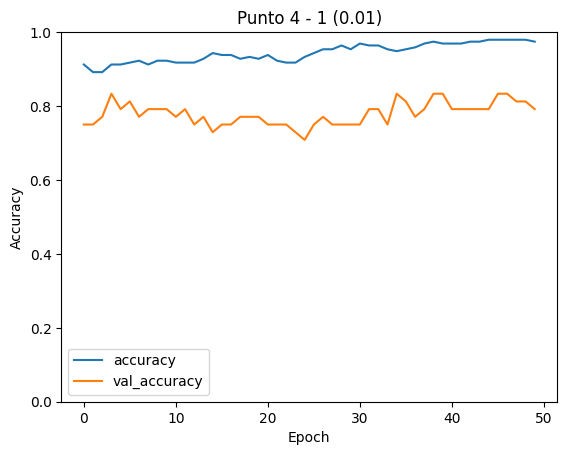

In [78]:
import matplotlib.pyplot as plt
plt.plot(history_4_1.history['accuracy'],label='accuracy')
plt.plot(history_4_1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 4 - 1 (0.01)")
plt.legend()

In [79]:
results_4_1 = model_4_1.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 4 - 1 (0.01)")
for name, value in zip(model_4_1.metrics_names, results_4_1):
    print(f"{name}: {value}")

Resultados Punto 4 - 1 (0.01)
loss: 0.5798757672309875
accuracy: 0.8032786846160889
precision_3: 0.7368420958518982
recall_3: 0.6666666865348816
roc_auc: 0.8928571939468384


## Punto 4 - 2 (tasa = 0.0001)

In [80]:
model_4_2 = keras.Model(inputs, model_layers)

In [81]:
learning_rate_2 = 0.0001
optimizer = Adam(learning_rate=learning_rate_2)
model_4_2.compile(optimizer=optimizer, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [82]:
model_4_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [83]:
history_4_2 = model_4_2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 4s 270ms/step - loss: 0.0929 - accuracy: 0.9794 - precision_4: 0.9423 - recall_4: 0.9800 - roc_auc: 0.9956 - val_loss: 0.4486 - val_accuracy: 0.7917 - val_precision_4: 0.5833 - val_recall_4: 0.5833 - val_roc_auc: 0.8762
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0925 - accuracy: 0.9794 - precision_4: 0.9423 - recall_4: 0.9800 - roc_auc: 0.9956 - val_loss: 0.4492 - val_accuracy: 0.7917 - val_precision_4: 0.5833 - val_recall_4: 0.5833 - val_roc_auc: 0.8762
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0922 - accuracy: 0.9794 - precision_4: 0.9423 - recall_4: 0.9800 - roc_auc: 0.9956 - val_loss: 0.4496 - val_accuracy: 0.7917 - val_precision_4: 0.5833 - val_recall_4: 0.5833 - val_roc_auc: 0.8750
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0920 - accuracy: 0.9794 - precision_4: 0.9423 - recall_4: 0.9800 - roc_auc: 0.9956 - val_loss: 0.4493 - val_accuracy: 0

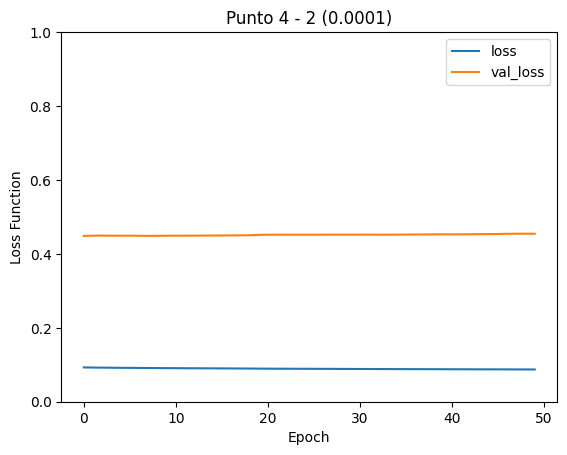

In [84]:
import matplotlib.pyplot as plt
plt.plot(history_4_2.history['loss'], label='loss')
plt.plot(history_4_2.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 4 - 2 (0.0001)")
plt.legend()

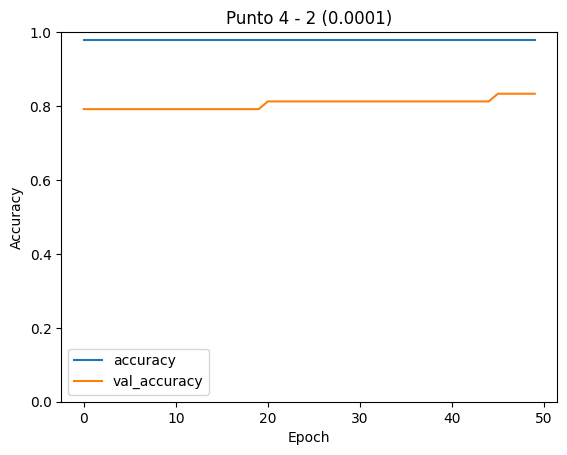

In [85]:
import matplotlib.pyplot as plt
plt.plot(history_4_2.history['accuracy'],label='accuracy')
plt.plot(history_4_2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 4 - 2 (0.0001)")
plt.legend()

In [86]:
results_4_2 = model_4_2.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 4 - 2 (0.0001)")
for name, value in zip(model_4_2.metrics_names, results_4_2):
    print(f"{name}: {value}")

Resultados Punto 4 - 2 (0.0001)
loss: 0.5855211615562439
accuracy: 0.7868852615356445
precision_4: 0.7222222089767456
recall_4: 0.6190476417541504
roc_auc: 0.874404788017273


## Punto 4 - 3 (tasa = 0.005)

In [87]:
model_4_3 = keras.Model(inputs, model_layers)

In [88]:
learning_rate_3 = 0.005
optimizer = Adam(learning_rate=learning_rate_3)
model_4_3.compile(optimizer=optimizer, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [89]:
model_4_3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [90]:
history_4_3 = model_4_3.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 4s 195ms/step - loss: 0.0983 - accuracy: 0.9794 - precision_5: 0.9423 - recall_5: 0.9800 - roc_auc: 0.9957 - val_loss: 0.4571 - val_accuracy: 0.8125 - val_precision_5: 0.6000 - val_recall_5: 0.7500 - val_roc_auc: 0.8657
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0868 - accuracy: 0.9794 - precision_5: 0.9423 - recall_5: 0.9800 - roc_auc: 0.9978 - val_loss: 0.4772 - val_accuracy: 0.8125 - val_precision_5: 0.6000 - val_recall_5: 0.7500 - val_roc_auc: 0.8657
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0849 - accuracy: 0.9794 - precision_5: 0.9423 - recall_5: 0.9800 - roc_auc: 0.9972 - val_loss: 0.4881 - val_accuracy: 0.8333 - val_precision_5: 0.6429 - val_recall_5: 0.7500 - val_roc_auc: 0.8750
Epoch 4/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0857 - accuracy: 0.9794 - precision_5: 0.9423 - recall_5: 0.9800 - roc_auc: 0.9973 - val_loss: 0.4928 - val_accuracy: 0

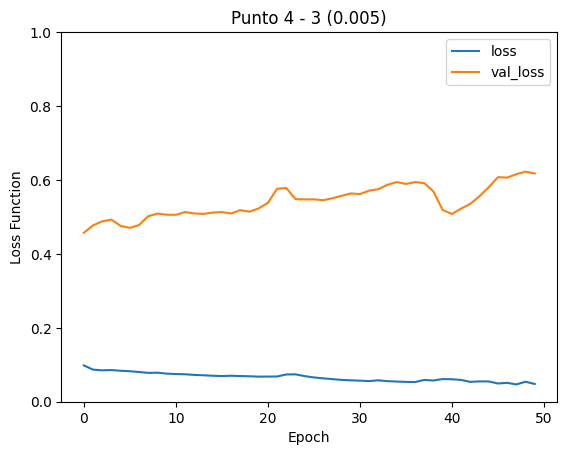

In [91]:
import matplotlib.pyplot as plt
plt.plot(history_4_3.history['loss'], label='loss')
plt.plot(history_4_3.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 4 - 3 (0.005)")
plt.legend()

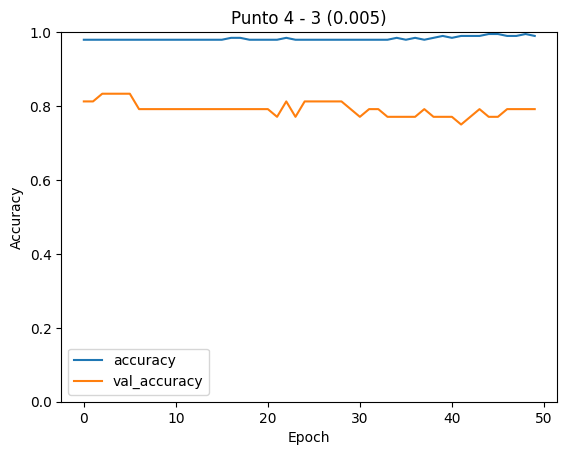

In [92]:
import matplotlib.pyplot as plt
plt.plot(history_4_3.history['accuracy'],label='accuracy')
plt.plot(history_4_3.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 4 - 3 (0.005)")
plt.legend()

In [93]:
results_4_3 = model_4_3.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 4 - 3 (0.005)")
for name, value in zip(model_4_3.metrics_names, results_4_3):
    print(f"{name}: {value}")

Resultados Punto 4 - 3 (0.005)
loss: 0.7526054978370667
accuracy: 0.7868852615356445
precision_5: 0.7222222089767456
recall_5: 0.6190476417541504
roc_auc: 0.8422619700431824


## Punto 6 - 1 (3 capas)

In [94]:
model_layers_3 = keras.layers.Dense(64, activation='relu')(all_feats)
model_layers_3 = keras.layers.Dense(32, activation='relu')(model_layers_3)
model_layers_3 = keras.layers.Dense(1, activation='sigmoid')(model_layers_3)

model_3_layers = keras.Model(inputs, model_layers_3)
model_3_layers.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=["accuracy", 
                                tf.keras.metrics.Precision(), 
                                tf.keras.metrics.Recall(), 
                                tf.keras.metrics.AUC(name='roc_auc')])

In [95]:
model_3_layers.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [96]:
history_6_1 = model_3_layers.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 7s 234ms/step - loss: 0.6686 - accuracy: 0.6753 - precision_6: 0.1579 - recall_6: 0.0600 - roc_auc: 0.3446 - val_loss: 0.6316 - val_accuracy: 0.7500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_roc_auc: 0.3935
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 0.6023 - accuracy: 0.7423 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - roc_auc: 0.5576 - val_loss: 0.5821 - val_accuracy: 0.7500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_roc_auc: 0.5579
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 0.5582 - accuracy: 0.7423 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - roc_auc: 0.7084 - val_loss: 0.5437 - val_accuracy: 0.7500 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_roc_auc: 0.6991
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.5245 - accuracy: 0.7423 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - roc_

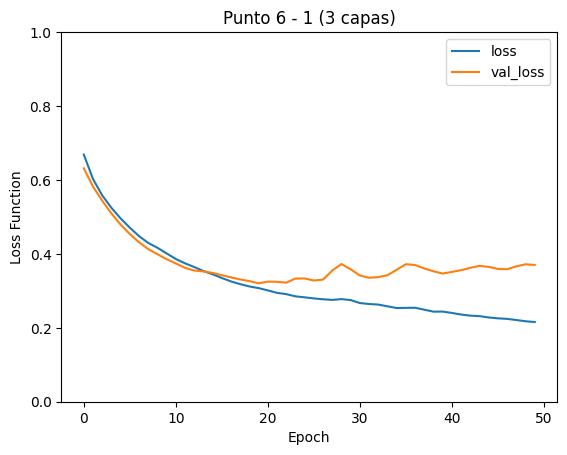

In [97]:
import matplotlib.pyplot as plt
plt.plot(history_6_1.history['loss'], label='loss')
plt.plot(history_6_1.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 6 - 1 (3 capas)")
plt.legend()

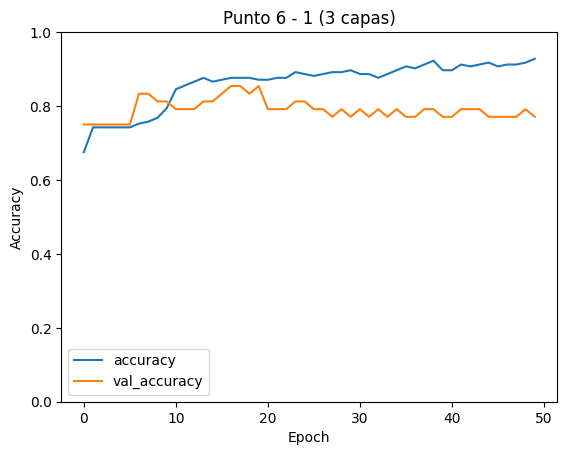

In [98]:
import matplotlib.pyplot as plt
plt.plot(history_6_1.history['accuracy'],label='accuracy')
plt.plot(history_6_1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 6 - 1 (3 capas)")
plt.legend()

In [99]:
results_6_1 = model_3_layers.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 6 - 1 (3 capas)")
for name, value in zip(model_3_layers.metrics_names, results_6_1):
    print(f"{name}: {value}")

Resultados Punto 6 - 1 (3 capas)
loss: 0.5010378956794739
accuracy: 0.7540983557701111
precision_6: 0.6666666865348816
recall_6: 0.5714285969734192
roc_auc: 0.8773809671401978


## Punto 6 - 2 (6 capas)

In [100]:
model_layers_6 = keras.layers.Dense(128, activation='relu')(all_feats)
model_layers_6 = keras.layers.Dense(64, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(64, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(32, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(32, activation='relu')(model_layers_6)
model_layers_6 = keras.layers.Dense(1, activation='sigmoid')(model_layers_6)

In [101]:
model_6_layers = keras.Model(inputs, model_layers_6)
model_6_layers.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=["accuracy", 
                                tf.keras.metrics.Precision(), 
                                tf.keras.metrics.Recall(), 
                                tf.keras.metrics.AUC(name='roc_auc')])

In [102]:
model_6_layers.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [103]:
history_6_2 = model_6_layers.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 6s 234ms/step - loss: 0.6473 - accuracy: 0.7423 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - roc_auc: 0.5396 - val_loss: 0.5888 - val_accuracy: 0.7500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_roc_auc: 0.7512
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.5491 - accuracy: 0.7423 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - roc_auc: 0.8164 - val_loss: 0.5006 - val_accuracy: 0.7500 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_roc_auc: 0.8380
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.4738 - accuracy: 0.7423 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - roc_auc: 0.8382 - val_loss: 0.4318 - val_accuracy: 0.7708 - val_precision_7: 1.0000 - val_recall_7: 0.0833 - val_roc_auc: 0.8692
Epoch 4/50
7/7 [==============================] - 0s 34ms/step - loss: 0.4155 - accuracy: 0.7680 - precision_7: 0.7778 - recall_7: 0.1400 - roc_auc: 0.8

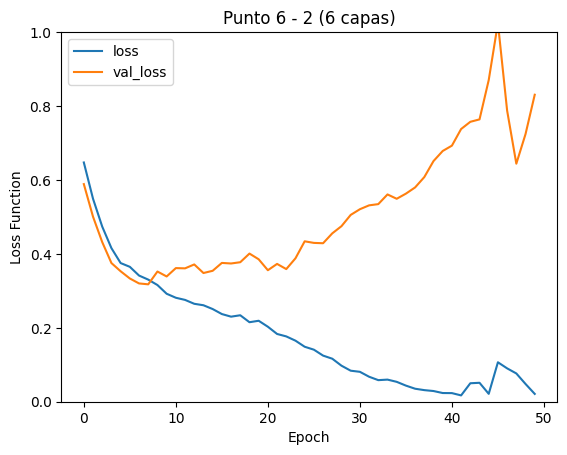

In [104]:
import matplotlib.pyplot as plt
plt.plot(history_6_2.history['loss'], label='loss')
plt.plot(history_6_2.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 6 - 2 (6 capas)")
plt.legend()

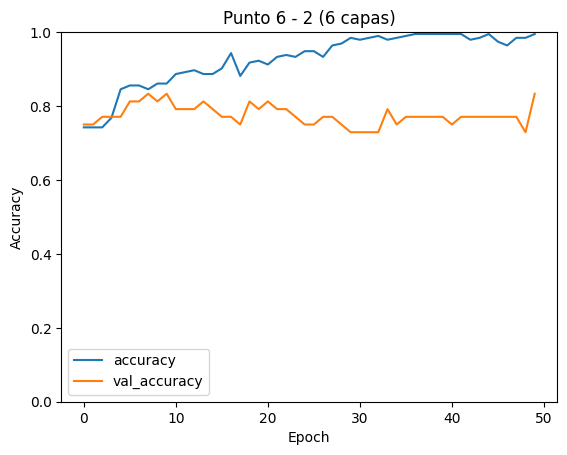

In [105]:
import matplotlib.pyplot as plt
plt.plot(history_6_2.history['accuracy'],label='accuracy')
plt.plot(history_6_2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 6 - 2 (6 capas)")
plt.legend()

In [106]:
results_6_2 = model_6_layers.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 6 - 2 (6 capas)")
for name, value in zip(model_6_layers.metrics_names, results_6_2):
    print(f"{name}: {value}")

Resultados Punto 6 - 2 (6 capas)
loss: 1.1399108171463013
accuracy: 0.7049180269241333
precision_7: 0.6363636255264282
recall_7: 0.3333333432674408
roc_auc: 0.8226190805435181


## Punto 6 - 3 (18 capas)

In [107]:
model_layers_18 = keras.layers.Dense(256, activation='relu')(all_feats)
for _ in range(16):
    model_layers_18 = keras.layers.Dense(128, activation='relu')(model_layers_18)
model_layers_18 = keras.layers.Dense(1, activation='sigmoid')(model_layers_18)

model_18_layers = keras.Model(inputs, model_layers_18)
model_18_layers.compile(optimizer='adam', 
                        loss='binary_crossentropy', 
                        metrics=["accuracy", 
                                 tf.keras.metrics.Precision(), 
                                 tf.keras.metrics.Recall(), 
                                 tf.keras.metrics.AUC(name='roc_auc')])


In [108]:
model_18_layers.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [109]:
history_6_3 = model_18_layers.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 11s 347ms/step - loss: 0.6467 - accuracy: 0.7423 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - roc_auc: 0.5424 - val_loss: 0.5068 - val_accuracy: 0.7500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_roc_auc: 0.8530
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 0.5004 - accuracy: 0.7423 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - roc_auc: 0.8406 - val_loss: 0.4199 - val_accuracy: 0.7500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_roc_auc: 0.8889
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.4089 - accuracy: 0.7423 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00 - roc_auc: 0.8921 - val_loss: 0.3273 - val_accuracy: 0.7500 - val_precision_8: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_roc_auc: 0.8970
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.4335 - accuracy: 0.7423 - precision_8: 0.0000e+00 - recall_8: 0.0000e+

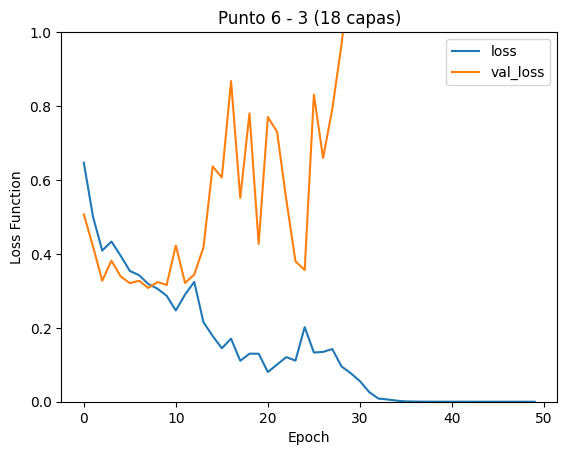

In [110]:
import matplotlib.pyplot as plt
plt.plot(history_6_3.history['loss'], label='loss')
plt.plot(history_6_3.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 6 - 3 (18 capas)")
plt.legend()

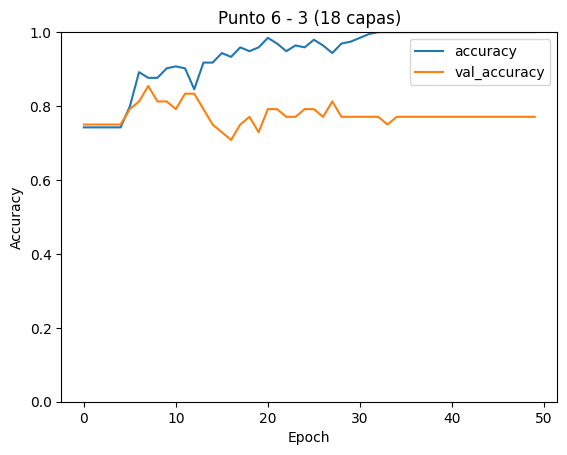

In [111]:
import matplotlib.pyplot as plt
plt.plot(history_6_3.history['accuracy'],label='accuracy')
plt.plot(history_6_3.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 6 - 3 (18 capas)")
plt.legend()

In [112]:
results_6_3 = model_18_layers.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 6 - 3 (18 capas)")
for name, value in zip(model_18_layers.metrics_names, results_6_3):
    print(f"{name}: {value}")

Resultados Punto 6 - 3 (18 capas)
loss: 6.305842876434326
accuracy: 0.8032786846160889
precision_8: 0.7368420958518982
recall_8: 0.6666666865348816
roc_auc: 0.7708333730697632


## Punto 7 - 1 (Tanh-sigmoid)

In [113]:
model_layers1 = keras.layers.Dense(32, activation='tanh')(all_feats)
model_layers1 = keras.layers.Dense(1, activation='sigmoid')(model_layers1)

In [114]:
model_7_1 = keras.Model(inputs, model_layers1)

In [115]:
model_7_1.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [116]:
model_7_1.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                            

In [117]:
history_7_1 = model_7_1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 6s 510ms/step - loss: 0.8440 - accuracy: 0.2990 - precision_9: 0.2133 - recall_9: 0.6400 - roc_auc: 0.3678 - val_loss: 0.7826 - val_accuracy: 0.3542 - val_precision_9: 0.2564 - val_recall_9: 0.8333 - val_roc_auc: 0.4375
Epoch 2/50
7/7 [==============================] - 0s 76ms/step - loss: 0.7575 - accuracy: 0.4021 - precision_9: 0.2339 - recall_9: 0.5800 - roc_auc: 0.4205 - val_loss: 0.7085 - val_accuracy: 0.5000 - val_precision_9: 0.2857 - val_recall_9: 0.6667 - val_roc_auc: 0.5567
Epoch 3/50
7/7 [==============================] - 0s 36ms/step - loss: 0.6858 - accuracy: 0.5619 - precision_9: 0.2785 - recall_9: 0.4400 - roc_auc: 0.5079 - val_loss: 0.6475 - val_accuracy: 0.6667 - val_precision_9: 0.3889 - val_recall_9: 0.5833 - val_roc_auc: 0.6551
Epoch 4/50
7/7 [==============================] - 0s 33ms/step - loss: 0.6267 - accuracy: 0.6598 - precision_9: 0.3400 - recall_9: 0.3400 - roc_auc: 0.6322 - val_loss: 0.5974 - val_accuracy: 0

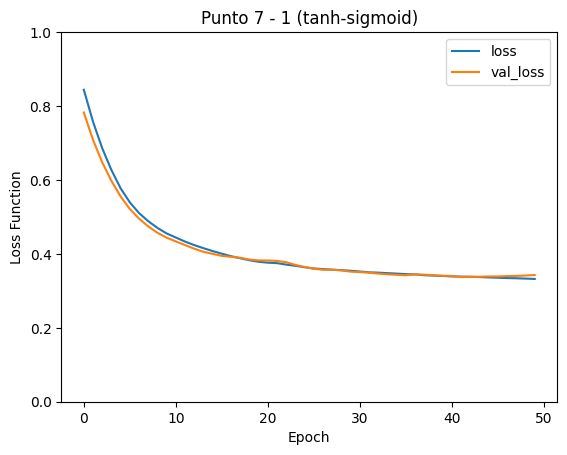

In [118]:
import matplotlib.pyplot as plt
plt.plot(history_7_1.history['loss'], label='loss')
plt.plot(history_7_1.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 7 - 1 (tanh-sigmoid)")
plt.legend()

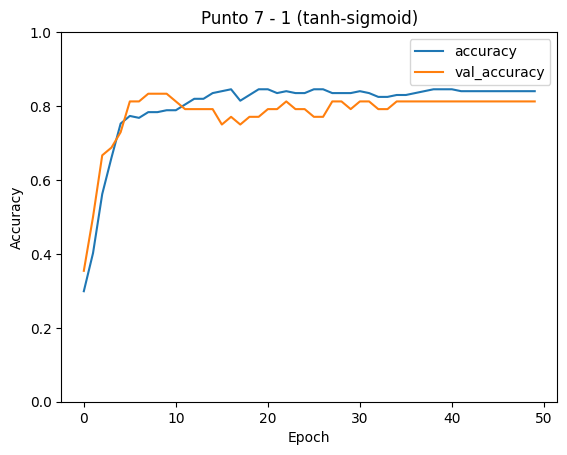

In [119]:
import matplotlib.pyplot as plt
plt.plot(history_7_1.history['accuracy'],label='accuracy')
plt.plot(history_7_1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 7 - 1 (tanh-sigmoid)")
plt.legend()

In [120]:
results_7_1 = model_7_1.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 7 - 1 (tanh-sigmoid)")
for name, value in zip(model_7_1.metrics_names, results_7_1):
    print(f"{name}: {value}")

Resultados Punto 7 - 1 (tanh-sigmoid)
loss: 0.42488279938697815
accuracy: 0.7704917788505554
precision_9: 0.7058823704719543
recall_9: 0.5714285969734192
roc_auc: 0.9083333015441895


## Punto 7 - 2 (sigmoid-relu)

In [121]:
model_layers2 = keras.layers.Dense(32, activation='sigmoid')(all_feats)
model_layers2 = keras.layers.Dense(1, activation='relu')(model_layers2)

In [122]:
model_7_2 = keras.Model(inputs, model_layers2)

In [123]:
model_7_2.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [124]:
model_7_2.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                           

In [125]:
history_7_2 = model_7_2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 9s 309ms/step - loss: 1.5978 - accuracy: 0.7268 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - roc_auc: 0.3782 - val_loss: 0.9272 - val_accuracy: 0.6875 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_roc_auc: 0.4444
Epoch 2/50
7/7 [==============================] - 0s 20ms/step - loss: 0.9049 - accuracy: 0.7165 - precision_10: 0.2727 - recall_10: 0.0600 - roc_auc: 0.4115 - val_loss: 0.6357 - val_accuracy: 0.6667 - val_precision_10: 0.1667 - val_recall_10: 0.0833 - val_roc_auc: 0.5093
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.6576 - accuracy: 0.6649 - precision_10: 0.2414 - recall_10: 0.1400 - roc_auc: 0.4603 - val_loss: 0.6312 - val_accuracy: 0.6667 - val_precision_10: 0.3000 - val_recall_10: 0.2500 - val_roc_auc: 0.5694
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.6434 - accuracy: 0.6546 - precision_10: 0.2571 - recall_10: 0.1800 - roc_auc: 0.4906 - val_

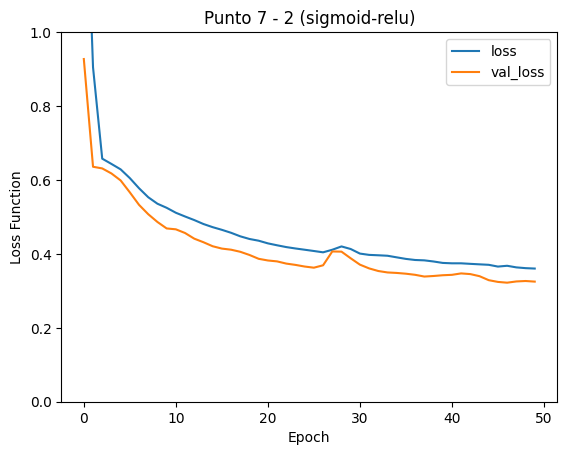

In [126]:
plt.plot(history_7_2.history['loss'], label='loss')
plt.plot(history_7_2.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 7 - 2 (sigmoid-relu)")
plt.legend()

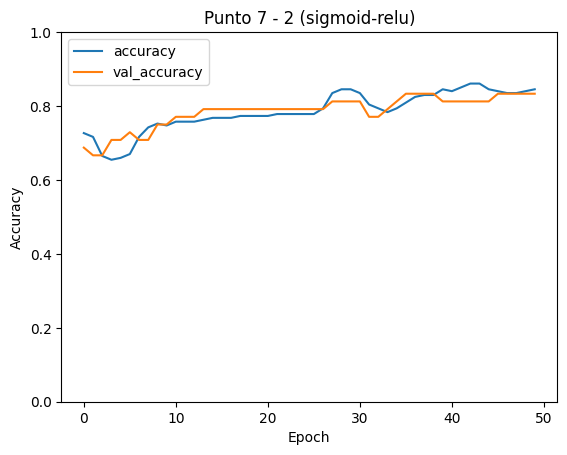

In [127]:
import matplotlib.pyplot as plt
plt.plot(history_7_2.history['accuracy'],label='accuracy')
plt.plot(history_7_2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 7 - 2 (sigmoid-relu)")
plt.legend()

In [128]:
results_7_2 = model_7_2.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 7 - 2 (sigmoid-relu)")
for name, value in zip(model_7_2.metrics_names, results_7_2):
    print(f"{name}: {value}")

Resultados Punto 7 - 2 (sigmoid-relu)
loss: 0.3875119984149933
accuracy: 0.7540983557701111
precision_10: 0.7142857313156128
recall_10: 0.4761904776096344
roc_auc: 0.8916666507720947


## Punto 7 - 3 (relu-tanh)

In [129]:
model_layers3 = keras.layers.Dense(32, activation='relu')(all_feats)
model_layers3 = keras.layers.Dense(1, activation='tanh')(model_layers3)

In [130]:
model_7_3 = keras.Model(inputs, model_layers3)

In [131]:
model_7_3.compile(optimizer='adam', loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [132]:
model_7_3.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                           

In [133]:
history_7_3 = model_7_3.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 4s 154ms/step - loss: 0.7942 - accuracy: 0.6959 - precision_11: 0.4043 - recall_11: 0.3800 - roc_auc: 0.6560 - val_loss: 0.7750 - val_accuracy: 0.7083 - val_precision_11: 0.4000 - val_recall_11: 0.3333 - val_roc_auc: 0.7188
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.7330 - accuracy: 0.7423 - precision_11: 0.5000 - recall_11: 0.4400 - roc_auc: 0.7131 - val_loss: 0.7366 - val_accuracy: 0.7292 - val_precision_11: 0.4545 - val_recall_11: 0.4167 - val_roc_auc: 0.7488
Epoch 3/50
7/7 [==============================] - 0s 10ms/step - loss: 0.5967 - accuracy: 0.7423 - precision_11: 0.5000 - recall_11: 0.4400 - roc_auc: 0.7526 - val_loss: 0.7232 - val_accuracy: 0.7500 - val_precision_11: 0.5000 - val_recall_11: 0.5000 - val_roc_auc: 0.7743
Epoch 4/50
7/7 [==============================] - 0s 23ms/step - loss: 0.5359 - accuracy: 0.7577 - precision_11: 0.5294 - recall_11: 0.5400 - roc_auc: 0.7847 - val_loss: 0.4775 - v

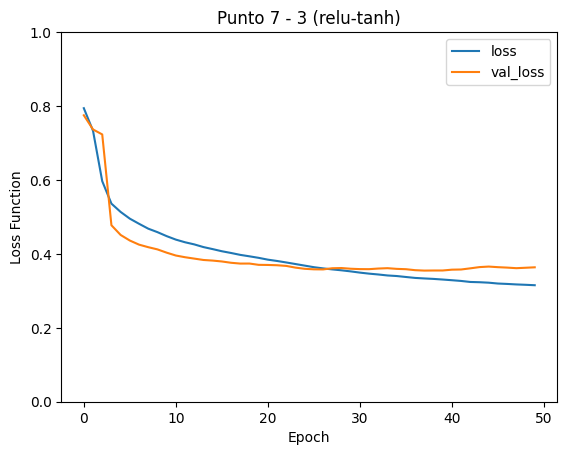

In [134]:
plt.plot(history_7_3.history['loss'], label='loss')
plt.plot(history_7_3.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 7 - 3 (relu-tanh)")
plt.legend()

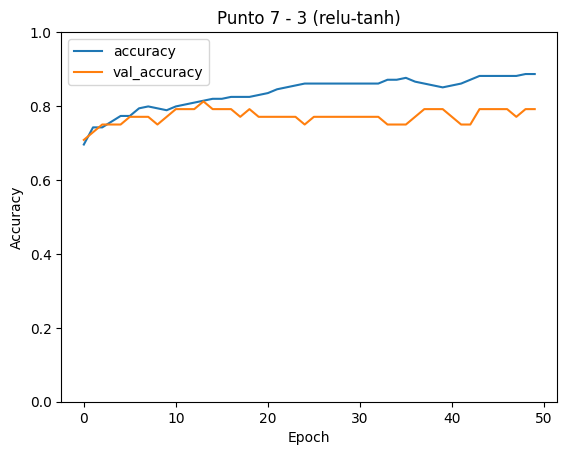

In [135]:
import matplotlib.pyplot as plt
plt.plot(history_7_3.history['accuracy'],label='accuracy')
plt.plot(history_7_3.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 7 - 3 (relu-tanh)")
plt.legend()

In [136]:
results_7_3 = model_7_3.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 7 - 3(relu-tanh)")
for name, value in zip(model_7_3.metrics_names, results_7_3):
    print(f"{name}: {value}")

Resultados Punto 7 - 3(relu-tanh)
loss: 0.8670336604118347
accuracy: 0.8032786846160889
precision_11: 0.7647058963775635
recall_11: 0.6190476417541504
roc_auc: 0.8553571701049805


## Punto 8 - 1 (SDG - (tanh-sigmoide))

In [146]:
model_layers8_1 = keras.layers.Dense(32, activation='tanh')(all_feats)
model_layers8_1 = keras.layers.Dense(1, activation='sigmoid')(model_layers8_1)

In [147]:
model_8_1 = keras.Model(inputs, model_layers8_1)

In [148]:
optimizer_8_1 = SGD(learning_rate=0.01, momentum=0.9)

In [149]:
model_8_1.compile(optimizer=optimizer_8_1, loss='binary_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='roc_auc')])

In [150]:
model_8_1.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                           

In [151]:
history_8_1 = model_8_1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 5s 274ms/step - loss: 0.5476 - accuracy: 0.7526 - precision_13: 0.5357 - recall_13: 0.3000 - roc_auc: 0.7422 - val_loss: 0.4983 - val_accuracy: 0.8125 - val_precision_13: 0.8000 - val_recall_13: 0.3333 - val_roc_auc: 0.8576
Epoch 2/50
7/7 [==============================] - 0s 22ms/step - loss: 0.4741 - accuracy: 0.7938 - precision_13: 0.7778 - recall_13: 0.2800 - roc_auc: 0.8338 - val_loss: 0.4179 - val_accuracy: 0.8333 - val_precision_13: 0.8333 - val_recall_13: 0.4167 - val_roc_auc: 0.8854
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.4166 - accuracy: 0.8196 - precision_13: 0.8261 - recall_13: 0.3800 - roc_auc: 0.8724 - val_loss: 0.3832 - val_accuracy: 0.7917 - val_precision_13: 0.6250 - val_recall_13: 0.4167 - val_roc_auc: 0.8889
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.3919 - accuracy: 0.8454 - precision_13: 0.7500 - recall_13: 0.6000 - roc_auc: 0.8824 - val_loss: 0.3917 - v

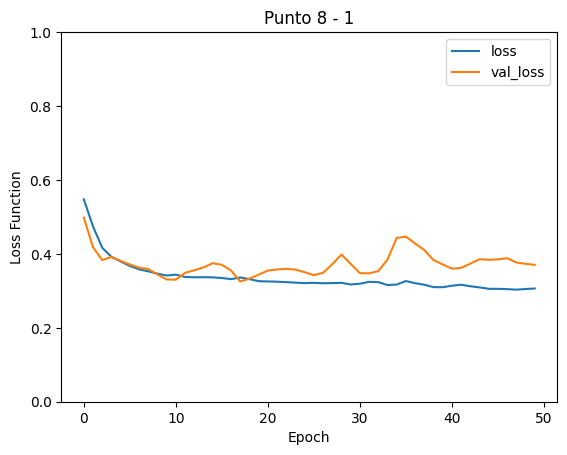

In [152]:
plt.plot(history_8_1.history['loss'], label='loss')
plt.plot(history_8_1.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 8 - 1")
plt.legend()

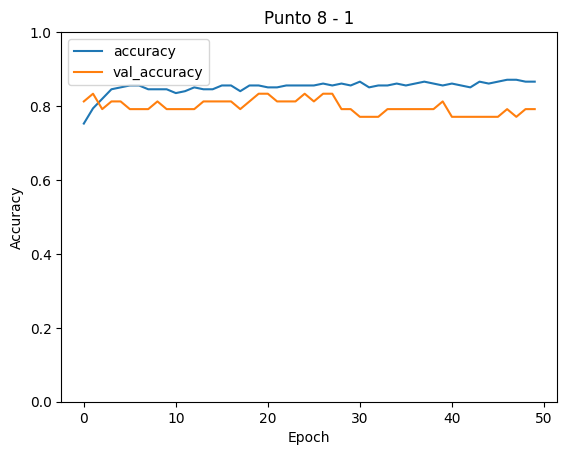

In [153]:
import matplotlib.pyplot as plt
plt.plot(history_8_1.history['accuracy'],label='accuracy')
plt.plot(history_8_1.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 8 - 1")
plt.legend()

In [154]:
results_8_1 = model_8_1.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 8 - 1")
for name, value in zip(model_8_1.metrics_names, results_8_1):
    print(f"{name}: {value}")

Resultados Punto 8 - 1
loss: 0.438331663608551
accuracy: 0.7704917788505554
precision_13: 0.7058823704719543
recall_13: 0.5714285969734192
roc_auc: 0.8982142210006714


## Punto 8 - 2 (RMS - (relu-sigmoide) - 3 capas)

In [155]:
model_layers8_2 = keras.layers.Dense(64, activation='relu')(all_feats)
model_layers8_2 = keras.layers.Dense(32, activation='relu')(model_layers8_2)
model_layers8_2 = keras.layers.Dense(1, activation='sigmoid')(model_layers8_2)

optimizer_8_2 = RMSprop(learning_rate=0.001)
model_8_2 = keras.Model(inputs, model_layers8_2)
model_8_2.compile(optimizer=optimizer_8_2, 
                       loss='binary_crossentropy', 
                       metrics=["accuracy", 
                                tf.keras.metrics.Precision(), 
                                tf.keras.metrics.Recall(), 
                                tf.keras.metrics.AUC(name='roc_auc')])

In [156]:
model_8_2.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sex (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 cp (InputLayer)             [(None, 1)]                  0         []                            
                                                                                                  
 fbs (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 exang (InputLayer)          [(None, 1)]                  0         []                            
                                                                                           

In [157]:
history_8_2 = model_8_2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
7/7 [==============================] - 6s 222ms/step - loss: 0.6799 - accuracy: 0.6031 - precision_14: 0.3579 - recall_14: 0.6800 - roc_auc: 0.6369 - val_loss: 0.5919 - val_accuracy: 0.6458 - val_precision_14: 0.3529 - val_recall_14: 0.5000 - val_roc_auc: 0.7407
Epoch 2/50
7/7 [==============================] - 0s 18ms/step - loss: 0.5420 - accuracy: 0.7577 - precision_14: 0.5429 - recall_14: 0.3800 - roc_auc: 0.8185 - val_loss: 0.5164 - val_accuracy: 0.8125 - val_precision_14: 0.6364 - val_recall_14: 0.5833 - val_roc_auc: 0.7975
Epoch 3/50
7/7 [==============================] - 0s 17ms/step - loss: 0.4820 - accuracy: 0.8041 - precision_14: 0.7727 - recall_14: 0.3400 - roc_auc: 0.8584 - val_loss: 0.4749 - val_accuracy: 0.7708 - val_precision_14: 0.5556 - val_recall_14: 0.4167 - val_roc_auc: 0.8380
Epoch 4/50
7/7 [==============================] - 0s 21ms/step - loss: 0.4469 - accuracy: 0.8144 - precision_14: 0.7917 - recall_14: 0.3800 - roc_auc: 0.8699 - val_loss: 0.4446 - v

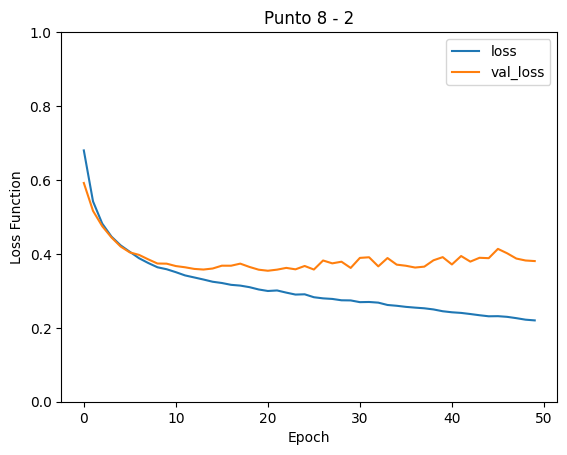

In [158]:
plt.plot(history_8_2.history['loss'], label='loss')
plt.plot(history_8_2.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.title("Punto 8 - 2")
plt.legend()

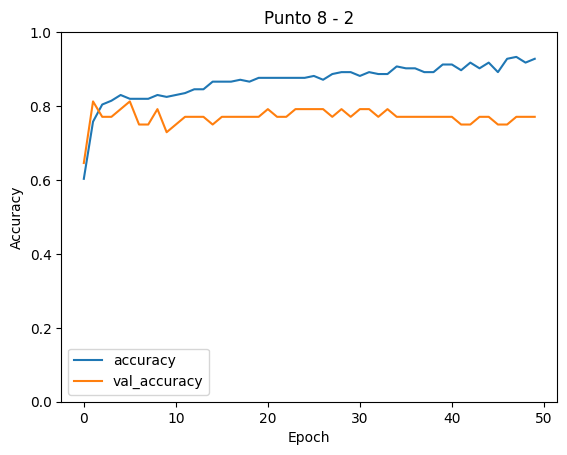

In [159]:
import matplotlib.pyplot as plt
plt.plot(history_8_2.history['accuracy'],label='accuracy')
plt.plot(history_8_2.history['val_accuracy'],label='val_accuracy')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Punto 8 - 2")
plt.legend()

In [160]:
results_8_2 = model_8_2.evaluate(test_ds, verbose=0)

# Assuming you have the metric names as defined in `model.metrics_names`
print("Resultados Punto 8 - 2")
for name, value in zip(model_8_2.metrics_names, results_8_2):
    print(f"{name}: {value}")

Resultados Punto 8 - 2
loss: 0.443706750869751
accuracy: 0.7868852615356445
precision_14: 0.7222222089767456
recall_14: 0.6190476417541504
roc_auc: 0.8886904716491699
